In [2]:
import math
import pytz
import pickle
import folium
import rasterio
import requests
import time

import geopandas as gpd
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from io import StringIO
from Py6S import *
from folium.plugins import HeatMap, AntPath
from datetime import datetime, timedelta
from timezonefinder import TimezoneFinder
from shapely.geometry import Point

In [3]:
q_table_path = 'q_table_2024-03-25-02-59-52.npy'
q_table = np.load(q_table_path)

In [4]:
with open('/Users/timothydonohue/Documents/Data/nasa_power_dict.pkl', 'rb') as pickle_file:
    data_dict = pickle.load(pickle_file)

In [5]:
speed = 13  # Speed in m/s
time_step = 3

earth_circumference_km = 40075
degrees_per_latitude = earth_circumference_km / 360
travel_distance_km = speed * time_step * 3600 / 1000

lat_range = 61  # 0 to 60 degrees inclusive is 61 degrees
degrees_per_step_lat = travel_distance_km / degrees_per_latitude
num_lat_steps = int(lat_range / degrees_per_step_lat)

lon_range = 31
representative_lat = 30
degrees_per_longitude_at_lat = np.cos(np.radians(representative_lat)) * degrees_per_latitude
degrees_per_step_lon = travel_distance_km / degrees_per_longitude_at_lat
num_lon_steps = int(lon_range / degrees_per_step_lon)

num_days = int(365 / 4)  # 3 months
num_daily_timesteps = int(24 / time_step)
num_time_steps = num_days * num_daily_timesteps

start_state = (22, 4, 0, 0)
optimal_path = [start_state]

In [6]:
def take_action(input_state, action_key):
    lat_index, lon_index, day_index, hour_index = input_state

    action_effects = {
        0: (1, 0),  # 'N'
        1: (1, 1),  # 'NE'
        2: (0, 1),  # 'E'
        3: (-1, 1),  # 'SE'
        4: (-1, 0),  # 'S'
        5: (-1, -1),  # 'SW'
        6: (0, -1),  # 'W'
        7: (1, -1),  # 'NW'
        8: (0, 0),  # 'STAY'
    }

    lat_change, lon_change = action_effects[action_key]

    new_lat_index = max(0, min(num_lat_steps - 1, lat_index + lat_change))
    new_lon_index = max(0, min(num_lon_steps - 1, lon_index + lon_change))

    new_time_index = min(day_index * num_daily_timesteps + hour_index + 1, num_time_steps - 1)
    new_day_index = new_time_index // num_daily_timesteps
    new_hour_index = new_time_index % num_daily_timesteps

    return new_lat_index, new_lon_index, new_day_index, new_hour_index

In [7]:
for step in range(num_time_steps):
    start_lat, start_lon, start_day, start_hour = start_state
    action = np.argmax(q_table[start_lat, start_lon, start_day, start_hour])
    next_state = take_action(start_state, action)
    
    optimal_path.append(next_state)
    
    start_state = next_state
    
    if start_state[2] == num_days - 1 and start_state[3] == num_daily_timesteps - 1:
        break

In [8]:
optimal_path[0:10]

[(22, 4, 0, 0),
 (23, 4, 0, 1),
 (22, 3, 0, 2),
 (22, 2, 0, 3),
 (22, 3, 0, 4),
 (22, 4, 0, 5),
 (22, 5, 0, 6),
 (23, 5, 0, 7),
 (24, 5, 1, 0),
 (23, 6, 1, 1)]

In [9]:
def est_dni_from_py6s(latitude, longitude, altitude, dthz):
    s = SixS()
    dthz_30 = dthz + timedelta(minutes=30)

    datetime_str = dthz_30.strftime('%Y-%m-%dT%H:%M:%S')
    s.atmos_profile = AtmosProfile.FromLatitudeAndDate(latitude, datetime_str)
    s.altitudes.set_target_custom_altitude(altitude / 1000)

    s.geometry = Geometry.User()
    s.geometry.from_time_and_location(latitude, longitude, datetime_str, 0, 0)

    if s.geometry.solar_z > 90:
        return 0

    s.run()

    dni = s.outputs.direct_solar_irradiance / math.cos(math.radians(s.outputs.solar_z))

    return dni


def adjust_dni_for_altitude(lat, lon, dthz, interpolated_sfc_dni):
    # Get DNI at 0m and 5400m
    dni_at_0m = est_dni_from_py6s(lat, lon, 0, dthz)
    dni_at_5400m = est_dni_from_py6s(lat, lon, 5400, dthz)

    # If dni_at_0m is 0, set the adjustment factor to 1, so the original NASA DNI is used
    if dni_at_0m == 0:
        adjustment_factor = 1
    else:
        adjustment_factor = dni_at_5400m / dni_at_0m

    # Calculate the adjusted DNI
    adjusted_dni = adjustment_factor * interpolated_sfc_dni

    return adjusted_dni


def bilinear_interpolation(lat, lon, datetime_obj, latitude_range=(0, 60), longitude_range=(-50, -20)):
    """
    Perform bilinear interpolation for a point (lat, lon) at a given datetime using a nested dictionary,
    adjust the DNI value based on altitude, and add both interpolated and adjusted values to the dictionary.
    lat - latitude, lon - longitude, datetime_obj - the specific datetime object for DNI values in UTC.
    lat_range - Tuple indicating the range of latitude values (default is (0, 60)).
    lon_range - Tuple indicating the range of longitude values (default is (-50, -20)).
    data_dict - nested dictionary structure {latitude: {longitude: {unix_timestamp: {'sfc_dni': value}}}}
    """
    unix_timestamp = int(datetime_obj.timestamp())

    # Slight perturbation inward for boundary points
    delta = 1e-6  # Small perturbation value
    if lat == latitude_range[1]:
        lat -= delta  # Slightly decrease lat if it's on the upper boundary
    elif lat == latitude_range[0]:
        lat += delta  # Slightly increase lat if it's on the lower boundary

    if lon == longitude_range[0]:
        lon += delta  # Slightly increase lon if it's on the left boundary
    elif lon == longitude_range[1]:
        lon -= delta  # Slightly decrease lon if it's on the right boundary

    if data_dict.get(lat) and data_dict[lat].get(lon) and data_dict[lat][lon].get(unix_timestamp):
        sfc_dni = data_dict[lat][lon][unix_timestamp].get('sfc_dni', float('nan'))

        if 'alt_adj_dni' not in data_dict[lat][lon][unix_timestamp]:
            data_dict[lat][lon][unix_timestamp]['alt_adj_dni'] = adjust_dni_for_altitude(lat,
                                                                                         lon,
                                                                                         datetime_obj,
                                                                                         sfc_dni)
        alt_adj_dni = data_dict[lat][lon][unix_timestamp]['alt_adj_dni']

        return sfc_dni, alt_adj_dni

    # Identify the grid cell boundaries
    lat_lower = float(int(lat))
    lat_upper = lat_lower + 1
    lon_left = float(int(lon)) if lon > 0 else float(int(lon) - 1)
    lon_right = lon_left + 1

    values = {}
    for lat_bound in ('lower', 'upper'):
        for lon_bound in ('left', 'right'):
            current_lat = lat_lower if lat_bound == 'lower' else lat_upper
            current_lon = lon_left if lon_bound == 'left' else lon_right

            key_name = f"value_{lat_bound}_{lon_bound}"
            values[key_name] = data_dict.get(
                current_lat, {}
            ).get(
                current_lon, {}
            ).get(
                unix_timestamp, {'sfc_dni': float('nan')}
            )['sfc_dni']

    # Normalized distances
    lat_diff = lat - lat_lower
    lon_diff = lon - lon_left

    # Bilinear interpolation formula
    interpolated_sfc_dni = (values['value_lower_left'] * (1 - lat_diff) * (1 - lon_diff) +
                            values['value_lower_right'] * (1 - lat_diff) * lon_diff +
                            values['value_upper_left'] * lat_diff * (1 - lon_diff) +
                            values['value_upper_right'] * lat_diff * lon_diff)

    alt_adj_dni = adjust_dni_for_altitude(lat, lon, datetime_obj, interpolated_sfc_dni)

    data_dict.setdefault(lat, {}).setdefault(lon, {})[unix_timestamp] = {'sfc_dni': interpolated_sfc_dni,
                                                                         'alt_adj_dni': alt_adj_dni}

    return interpolated_sfc_dni, alt_adj_dni


def convert_state_to_sensible_values(state_indices, latitude_range=(0, 60), longitude_range=(-50, -20)):
    lat_index, lon_index, day_index, hour_index = state_indices

    # Adjust geo_lat calculation based on the provided lat_range
    geo_lat = ((lat_index / (num_lat_steps - 1)) * abs(latitude_range[0] - latitude_range[1])) + latitude_range[0]

    # Adjust geo_lon calculation based on the provided lon_range
    # Using abs() to ensure the correct step calculation for negative ranges
    geo_lon = ((lon_index / (num_lon_steps - 1)) * abs(longitude_range[0] - longitude_range[1])) + longitude_range[0]

    hours = day_index * 24 + hour_index * time_step
    dthz = datetime(2022, 3, 20, tzinfo=pytz.utc) + timedelta(hours=hours)

    tf = TimezoneFinder()
    time_zone_str = tf.timezone_at(lat=geo_lat, lng=geo_lon)

    if time_zone_str:
        time_zone = pytz.timezone(time_zone_str)
        dthl = dthz.astimezone(time_zone)
    else:
        # Calculate local time adjustment based on longitude
        local_time_offset = timedelta(hours=geo_lon / 15)
        dthl = dthz + local_time_offset

    return geo_lat, geo_lon, dthz, dthl

In [10]:
data = []

for state in optimal_path:
    action = np.argmax(q_table[state])
    q_value = q_table[state + (action,)]

    # Convert state indices to geographic coordinates and time
    coord_lat, coord_lon, datehour_utc, datehour_local = convert_state_to_sensible_values(state)

    # Get sfc_dni and alt_adj_dni using bilinear interpolation
    surface_dni, altitude_adj_dni = bilinear_interpolation(coord_lat, coord_lon, datehour_utc, data_dict)

    # Append data for this step
    data.append({
        'datehour_utc': datehour_utc,
        'datehour_local': datehour_local,
        'lat': coord_lat,
        'lon': coord_lon,
        'surface_dni': surface_dni,
        'altitude_adj_dni': altitude_adj_dni,
        'q_value': q_value
    })

# Create the DataFrame
df = pd.DataFrame(data)
df.index.name = 'step'
df.head()

,datehour_utc,datehour_local,lat,lon,surface_dni,altitude_adj_dni,q_value
step,,,,,,,
0,2022-03-20 00:00:00+00:00,2022-03-19 21:00:00-03:00,28.085106,-44.0,0.000000,0.000000,9151.856285
1,2022-03-20 03:00:00+00:00,2022-03-20 00:00:00-03:00,29.361702,-44.0,0.000000,0.000000,9633.532932
2,2022-03-20 06:00:00+00:00,2022-03-20 03:00:00-03:00,28.085106,-45.5,0.000000,0.000000,10140.560981
3,2022-03-20 09:00:00+00:00,2022-03-20 06:00:00-03:00,28.085106,-47.0,221.359149,885.436596,9742.236195
4,2022-03-20 12:00:00+00:00,2022-03-20 09:00:00-03:00,28.085106,-45.5,871.575532,965.883758,9238.265723


In [11]:
df.tail(50)

,datehour_utc,datehour_local,lat,lon,surface_dni,altitude_adj_dni,q_value
step,,,,,,,
678,2022-06-12 18:00:00+00:00,2022-06-12 15:00:00-03:00,30.638298,-47.0,817.141277,902.057153,9492.723473
679,2022-06-12 21:00:00+00:00,2022-06-12 18:00:00-03:00,30.638298,-47.0,345.930638,599.222224,9361.580261
680,2022-06-13 00:00:00+00:00,2022-06-12 21:00:00-03:00,31.914894,-47.0,0.000000,0.000000,9854.295012
681,2022-06-13 03:00:00+00:00,2022-06-13 00:00:00-03:00,33.191489,-47.0,0.000000,0.000000,10372.942118
682,2022-06-13 06:00:00+00:00,2022-06-13 03:00:00-03:00,33.191489,-45.5,0.000000,0.000000,10918.886440
683,2022-06-13 09:00:00+00:00,2022-06-13 06:00:00-03:00,31.914894,-44.0,678.501064,840.808951,10608.502620
684,2022-06-13 12:00:00+00:00,2022-06-13 09:00:00-03:00,30.638298,-45.5,910.222766,990.406094,10124.312133
685,2022-06-13 15:00:00+00:00,2022-06-13 12:00:00-03:00,31.914894,-47.0,872.537021,936.389860,9671.497129
686,2022-06-13 18:00:00+00:00,2022-06-13 15:00:00-03:00,31.914894,-48.5,857.384149,944.264446,9186.560719


In [12]:
df['coords'] = list(zip(df['lat'], df['lon']))
df.head()

,datehour_utc,datehour_local,lat,lon,surface_dni,altitude_adj_dni,q_value,coords
step,,,,,,,,
0,2022-03-20 00:00:00+00:00,2022-03-19 21:00:00-03:00,28.085106,-44.0,0.000000,0.000000,9151.856285,"(28.085106382978722, -44.0)"
1,2022-03-20 03:00:00+00:00,2022-03-20 00:00:00-03:00,29.361702,-44.0,0.000000,0.000000,9633.532932,"(29.361702127659573, -44.0)"
2,2022-03-20 06:00:00+00:00,2022-03-20 03:00:00-03:00,28.085106,-45.5,0.000000,0.000000,10140.560981,"(28.085106382978722, -45.5)"
3,2022-03-20 09:00:00+00:00,2022-03-20 06:00:00-03:00,28.085106,-47.0,221.359149,885.436596,9742.236195,"(28.085106382978722, -47.0)"
4,2022-03-20 12:00:00+00:00,2022-03-20 09:00:00-03:00,28.085106,-45.5,871.575532,965.883758,9238.265723,"(28.085106382978722, -45.5)"


In [13]:
df['coords'].value_counts()

coords
(22.97872340425532, -50.0)     20
(22.97872340425532, -48.5)     18
(26.80851063829787, -47.0)     15
(31.914893617021278, -47.0)    13
(25.53191489361702, -47.0)     12
                               ..
(25.53191489361702, -36.5)      1
(29.361702127659573, -50.0)     1
(37.02127659574468, -45.5)      1
(19.148936170212767, -48.5)     1
(24.25531914893617, -41.0)      1
Name: count, Length: 160, dtype: int64

In [14]:
df['altitude_adj_dni'].describe()

count     728.000000
mean      484.073401
std       435.375419
min         0.000000
25%         0.000000
50%       622.394681
75%       923.656748
max      1060.431833
Name: altitude_adj_dni, dtype: float64

In [15]:
df['surface_dni'].describe()

count    728.000000
mean     403.240724
std      394.169798
min        0.000000
25%        0.000000
50%      267.029662
75%      838.386729
max      986.097646
Name: surface_dni, dtype: float64

In [16]:
484.073401 / 403.240724

1.2004576229260018

In [17]:
484.073401 / 1000 * 24

11.617761624

In [18]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

# Initialize the map at the mean location
m = folium.Map(location=[gdf['lat'].mean(), gdf['lon'].mean()], zoom_start=4)

# Prepare data for the HeatMap
# If you have specific duration data, use it. Otherwise, consider each point as a single occurrence.
heat_data = [[row['lat'], row['lon']] for index, row in gdf.iterrows()]

# Add HeatMap to the map
HeatMap(heat_data, radius=15).add_to(m)

# Display the map
m


In [19]:
path_data = df['coords'].tolist()

# Initialize the map at the first location, adjusting the zoom level as needed
m = folium.Map(location=path_data[0], zoom_start=4)

# Add AntPath to the map to visualize the path
AntPath(locations=path_data).add_to(m)

# Display the map
m

In [20]:
df['lat'].describe()

count    728.000000
mean      26.975099
std        5.105198
min       14.042553
25%       22.978723
50%       26.808511
75%       30.638298
max       40.851064
Name: lat, dtype: float64

In [22]:
# calculate percentage of time spent at or below 35 degrees latitude
df[df['lat'] < 35].shape[0] / df.shape[0]

0.9285714285714286

In [116]:
df['lon'].describe()

count    728.000000
mean     -44.618132
std        4.071547
min      -50.000000
25%      -48.500000
50%      -45.500000
75%      -42.500000
max      -33.500000
Name: lon, dtype: float64

In [28]:
file_path = "/Users/timothydonohue/Documents/Data/nsrdbv3_dni/Annual DNI/nsrdb3_dni.tif"

# Define the CONUS bounding box
lat_north = 49.384358
lat_south = 24.396308
lon_east = -66.93457
lon_west = -124.848974

# Open the raster file
with rasterio.open(file_path) as src:
    # Read the data
    data = src.read(1)  # Read the first band

    # Get the affine transformation for the raster
    transform = src.transform

    # Replace any nodata values with NaNs
    data[data == src.nodata] = np.nan

    # Create an array of latitudes and longitudes
    cols, rows = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

    # Flatten all arrays to enable DataFrame creation
    flat_data = data.flatten()
    flat_xs = np.array(xs).flatten()
    flat_ys = np.array(ys).flatten()

    # Create a DataFrame
    df = pd.DataFrame({
        'latitude': flat_ys,
        'longitude': flat_xs,
        'dni': flat_data
    })

    # Drop rows with NaN values (if any)
    df.dropna(subset=['dni'], inplace=True)

    # Filter for points within the CONUS bounding box
    # conus_df = df[(df['latitude'] >= lat_south) & (df['latitude'] <= lat_north) &
    #               (df['longitude'] >= lon_west) & (df['longitude'] <= lon_east)]
    # 
    # Sort the DataFrame based on DNI values in descending order
    # df_sorted = conus_df.sort_values(by='dni', ascending=False)

    # Select the top 100 DNI locations
    top_100_dni = df.sort_values(by='dni', ascending=False).head(100).copy()
    
top_100_dni.reset_index(drop=True, inplace=True)
top_100_dni.head(25)

,latitude,longitude,dni
0,-20.47,-68.30,10.344000
1,-20.47,-68.34,10.248000
2,-20.63,-67.62,10.200000
3,-20.63,-68.10,10.176000
4,-20.43,-67.90,10.176000
5,-20.63,-67.66,10.151999
6,-20.63,-68.30,10.151999
7,-20.47,-67.90,10.151999
8,-20.51,-68.66,10.151999
9,-19.95,-68.30,10.128000


In [29]:
def create_normals_from_nasa_power(lat, lon):    
    url = f"https://power.larc.nasa.gov/api/temporal/monthly/point?start=1998&end=2016&latitude={lat}&longitude={lon}&community=sb&parameters=ALLSKY_SFC_SW_DNI&format=csv&header=false"
    
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.content.decode('utf-8')
        df = pd.read_csv(StringIO(data), header=0)
        normal = df['ANN'].mean()
        normal_kwh = normal / 1000 * 24
        return normal_kwh
    else:
        print(f"Failed to fetch data for {lat}, {lon}")
        return None


In [30]:
# iterate through the top 100 DNI locations and add the normals to the DataFrame
for index, row in top_100_dni.iterrows():
    print(f"Processing row {index + 1} of 100")
    lat = row['latitude']
    lon = row['longitude']
    normal = create_normals_from_nasa_power(lat, lon)
    top_100_dni.loc[index, 'nasa_normal'] = normal
    
top_100_dni.head(25)

Processing row 1 of 100
Processing row 2 of 100
Processing row 3 of 100
Processing row 4 of 100
Processing row 5 of 100
Processing row 6 of 100
Processing row 7 of 100
Processing row 8 of 100
Processing row 9 of 100
Processing row 10 of 100
Processing row 11 of 100
Processing row 12 of 100
Processing row 13 of 100
Processing row 14 of 100
Processing row 15 of 100
Processing row 16 of 100
Processing row 17 of 100
Processing row 18 of 100
Processing row 19 of 100
Processing row 20 of 100
Processing row 21 of 100
Processing row 22 of 100
Processing row 23 of 100
Processing row 24 of 100
Processing row 25 of 100
Processing row 26 of 100
Processing row 27 of 100
Processing row 28 of 100
Processing row 29 of 100
Processing row 30 of 100
Processing row 31 of 100
Processing row 32 of 100
Processing row 33 of 100
Processing row 34 of 100
Processing row 35 of 100
Processing row 36 of 100
Processing row 37 of 100
Processing row 38 of 100
Processing row 39 of 100
Processing row 40 of 100
Processin

,latitude,longitude,dni,nasa_normal
0,-20.47,-68.30,10.344000,8.059530
1,-20.47,-68.34,10.248000,8.059530
2,-20.63,-67.62,10.200000,5.208060
3,-20.63,-68.10,10.176000,8.059530
4,-20.43,-67.90,10.176000,5.208060
5,-20.63,-67.66,10.151999,5.208060
6,-20.63,-68.30,10.151999,8.059530
7,-20.47,-67.90,10.151999,5.208060
8,-20.51,-68.66,10.151999,8.059530
9,-19.95,-68.30,10.128000,7.573125


In [31]:
top_100_dni.to_csv("/Users/timothydonohue/Documents/Data/nsrdb_vs_nasa.csv", index=False)
top_100_dni.head(25)

,latitude,longitude,dni,nasa_normal
0,-20.47,-68.30,10.344000,8.059530
1,-20.47,-68.34,10.248000,8.059530
2,-20.63,-67.62,10.200000,5.208060
3,-20.63,-68.10,10.176000,8.059530
4,-20.43,-67.90,10.176000,5.208060
5,-20.63,-67.66,10.151999,5.208060
6,-20.63,-68.30,10.151999,8.059530
7,-20.47,-67.90,10.151999,5.208060
8,-20.51,-68.66,10.151999,8.059530
9,-19.95,-68.30,10.128000,7.573125


In [33]:
nsrdb_avg = top_100_dni['dni'].mean() 
nasa_avg = top_100_dni['nasa_normal'].mean()
print(nsrdb_avg, nasa_avg)
nasa_avg / nsrdb_avg - 1

10.023599870000002 7.234902


-0.27821320744719646

In [4]:
file_path = "/Users/timothydonohue/Documents/Data/nsrdbv3_dni/Annual DNI/nsrdb3_dni.tif"

# Open the raster file
with rasterio.open(file_path) as src:
    # Read the data
    data = src.read(1)  # Read the first band

    # Get the affine transformation for the raster
    transform = src.transform

    # Replace any nodata values with NaNs
    data[data == src.nodata] = np.nan

    # Create an array of latitudes and longitudes
    cols, rows = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))
    xs, ys = rasterio.transform.xy(transform, rows, cols, offset='center')

    # Flatten all arrays to enable DataFrame creation
    flat_data = data.flatten()
    flat_xs = np.array(xs).flatten()
    flat_ys = np.array(ys).flatten()

    # Create a DataFrame
    df = pd.DataFrame({
        'latitude': flat_ys,
        'longitude': flat_xs,
        'dni': flat_data
    })

    # Drop rows with NaN values (if any)
    df.dropna(subset=['dni'], inplace=True)

    # Calculate the average DNI for the entire dataset
    average_dni = df['dni'].mean()
    
americas_avg_daily_irradiance = average_dni / 24 * 1000
americas_avg_daily_irradiance

197.66233023551354

In [34]:
def fetch_data(lat_min, lon_min): 
    lat_max = lat_min + 10
    lon_max = lon_min + 10
    url = f"https://power.larc.nasa.gov/api/temporal/monthly/regional?start=2008&end=2022&latitude-min={lat_min}&latitude-max={lat_max}&longitude-min={lon_min}&longitude-max={lon_max}&community=sb&parameters=ALLSKY_SFC_SW_DNI&format=csv&header=true"
    response = requests.get(url, headers={"accept": "application/json"})
    if response.status_code == 200:
        data = response.content.decode('utf-8')

        # Find the end of the header
        end_of_header = data.find("-END HEADER-") + len("-END HEADER-\n")
        data_no_header = data[end_of_header:]

        try:
            df = pd.read_csv(StringIO(data_no_header))
            return df
        except Exception as e:
            print(f"Error parsing data for {lat_min}-{lat_max}, {lon_min}-{lon_max}")
            return pd.DataFrame()
    else:
        print(f"Failed to fetch data for {lat_min}-{lat_max}, {lon_min}-{lon_max}")
        return pd.DataFrame()

In [35]:
conus_15y_end_2022_df = pd.DataFrame()

for lon in range(-70, -131, -10):  # Step is -1 because we're moving from east to west
    for lat in range(25, 56, 10):
        df = fetch_data(lat, lon)
        if not df.empty:
            conus_15y_end_2022_df = pd.concat([conus_15y_end_2022_df, df], ignore_index=True)

conus_15y_end_2022_df.to_csv("/Users/timothydonohue/Documents/Data/nasa_power_conus_15y_end_2022.csv", index=False)
conus_15y_end_2022_df.head()

,PARAMETER,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN
0,ALLSKY_SFC_SW_DNI,2008,25.25,-60.25,211.61,275.07,243.36,268.93,206.05,283.44,298.57,230.69,159.78,195.17,186.74,208.88,230.52
1,ALLSKY_SFC_SW_DNI,2008,25.25,-60.75,211.61,275.07,243.36,268.93,206.05,283.44,298.57,230.69,159.78,195.17,186.74,208.88,230.52
2,ALLSKY_SFC_SW_DNI,2008,25.25,-61.25,213.12,274.55,241.45,256.88,218.04,282.48,286.53,221.89,152.70,213.87,193.52,195.83,229.08
3,ALLSKY_SFC_SW_DNI,2008,25.25,-61.75,213.12,274.55,241.45,256.88,218.04,282.48,286.53,221.89,152.70,213.87,193.52,195.83,229.08
4,ALLSKY_SFC_SW_DNI,2008,25.25,-62.25,212.05,281.24,234.78,250.20,209.68,288.66,281.31,221.57,146.63,231.25,202.82,192.87,229.22


In [36]:
conus_15y_end_2022_df.shape

(168000, 17)

In [37]:
nasa_normals = conus_15y_end_2022_df.groupby(['LAT', 'LON'])['ANN'].mean().reset_index()
nasa_normals.head()

,LAT,LON,ANN
0,25.25,-129.75,135.566
1,25.25,-129.25,135.566
2,25.25,-128.75,134.752
3,25.25,-128.25,134.752
4,25.25,-127.75,134.498


In [40]:
nasa_normals['DNI_kwh'] = nasa_normals['ANN'] / 1000 * 24
nasa_normals.head()

,LAT,LON,ANN,DNI_kwh
0,25.25,-129.75,135.566,3.253584
1,25.25,-129.25,135.566,3.253584
2,25.25,-128.75,134.752,3.234048
3,25.25,-128.25,134.752,3.234048
4,25.25,-127.75,134.498,3.227952


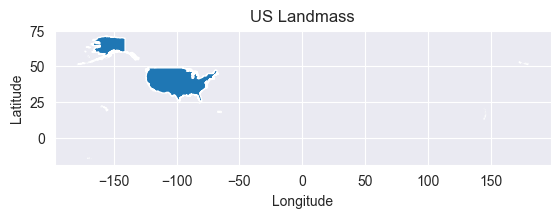

In [43]:
# Load a shapefile or GeoJSON file representing the US landmass
us_map = gpd.read_file('/Users/timothydonohue/Downloads/cb_2018_us_nation_5m/cb_2018_us_nation_5m.shp')

us_map.plot()

plt.title('US Landmass')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [44]:
# Create a GeoDataFrame from your nasa_normals DataFrame
# Assume nasa_normals has 'LAT' and 'LON' columns
gdf = gpd.GeoDataFrame(nasa_normals, geometry=gpd.points_from_xy(nasa_normals.LON, nasa_normals.LAT))

# Check if each point is within the US landmass
gdf['in_us'] = gdf.apply(lambda row: us_map.contains(row['geometry']).any(), axis=1)
gdf.head()

,LAT,LON,ANN,DNI_kwh,geometry,in_us
0,25.25,-129.75,135.566,3.253584,POINT (-129.75000 25.25000),False
1,25.25,-129.25,135.566,3.253584,POINT (-129.25000 25.25000),False
2,25.25,-128.75,134.752,3.234048,POINT (-128.75000 25.25000),False
3,25.25,-128.25,134.752,3.234048,POINT (-128.25000 25.25000),False
4,25.25,-127.75,134.498,3.227952,POINT (-127.75000 25.25000),False


In [45]:
gdf.sort_values(by='DNI_kwh', ascending=False).head(25)

,LAT,LON,ANN,DNI_kwh,geometry,in_us
1432,30.25,-113.75,340.290667,8.166976,POINT (-113.75000 30.25000),False
1573,30.75,-113.25,340.290667,8.166976,POINT (-113.25000 30.75000),False
1572,30.75,-113.75,340.290667,8.166976,POINT (-113.75000 30.75000),False
1433,30.25,-113.25,340.290667,8.166976,POINT (-113.25000 30.25000),False
2547,34.25,-116.25,339.493333,8.147840,POINT (-116.25000 34.25000),True
2546,34.25,-116.75,339.493333,8.147840,POINT (-116.75000 34.25000),True
2686,34.75,-116.75,339.493333,8.147840,POINT (-116.75000 34.75000),True
2687,34.75,-116.25,339.493333,8.147840,POINT (-116.25000 34.75000),True
2133,32.75,-113.25,336.038000,8.064912,POINT (-113.25000 32.75000),True
2132,32.75,-113.75,336.038000,8.064912,POINT (-113.75000 32.75000),True


In [46]:
us_land_points = gdf[gdf['in_us']].sort_values(by='ANN', ascending=False)
print(us_land_points['DNI_kwh'].describe())
us_land_points.head(25)

count    3278.000000
mean        5.303279
std         1.104483
min         3.153168
25%         4.565056
50%         4.960920
75%         5.935664
max         8.147840
Name: DNI_kwh, dtype: float64


,LAT,LON,ANN,DNI_kwh,geometry,in_us
2547,34.25,-116.25,339.493333,8.147840,POINT (-116.25000 34.25000),True
2686,34.75,-116.75,339.493333,8.147840,POINT (-116.75000 34.75000),True
2687,34.75,-116.25,339.493333,8.147840,POINT (-116.25000 34.75000),True
2546,34.25,-116.75,339.493333,8.147840,POINT (-116.75000 34.25000),True
2133,32.75,-113.25,336.038000,8.064912,POINT (-113.25000 32.75000),True
2132,32.75,-113.75,336.038000,8.064912,POINT (-113.75000 32.75000),True
1993,32.25,-113.25,336.038000,8.064912,POINT (-113.25000 32.25000),True
1992,32.25,-113.75,336.038000,8.064912,POINT (-113.75000 32.25000),True
2964,35.75,-117.75,335.382667,8.049184,POINT (-117.75000 35.75000),True
2965,35.75,-117.25,335.382667,8.049184,POINT (-117.25000 35.75000),True


In [75]:
(df['altitude_adj_dni'].mean() / 1000 * 24) / us_land_points['DNI_kwh'].max()

1.425870122714257

In [119]:
conus_2022_df = pd.read_csv("/Users/timothydonohue/Downloads/nasa_power_conus_ann.csv")
conus_2022_df.shape

(4000, 17)

In [120]:
conus_2022_df['ANN'].describe()

count    4000.000000
mean      212.851420
std        45.613674
min       122.090000
25%       180.547500
50%       212.070000
75%       232.755000
max       322.500000
Name: ANN, dtype: float64

In [121]:
conus_2022_df.sort_values(by='ANN', ascending=False).head(25)

,PARAMETER,YEAR,LAT,LON,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN
3499,ALLSKY_SFC_SW_DNI,2022,32.25,-109.75,269.09,362.41,359.34,429.16,448.09,312.84,282.04,266.34,308.66,290.34,319.61,228.54,322.50
3519,ALLSKY_SFC_SW_DNI,2022,32.75,-109.75,269.09,362.41,359.34,429.16,448.09,312.84,282.04,266.34,308.66,290.34,319.61,228.54,322.50
3498,ALLSKY_SFC_SW_DNI,2022,32.25,-109.25,269.09,362.41,359.34,429.16,448.09,312.84,282.04,266.34,308.66,290.34,319.61,228.54,322.50
3518,ALLSKY_SFC_SW_DNI,2022,32.75,-109.25,269.09,362.41,359.34,429.16,448.09,312.84,282.04,266.34,308.66,290.34,319.61,228.54,322.50
3296,ALLSKY_SFC_SW_DNI,2022,27.25,-108.25,302.44,354.11,408.34,421.55,449.32,295.45,195.83,175.37,241.23,360.01,362.38,287.38,320.74
3297,ALLSKY_SFC_SW_DNI,2022,27.25,-108.75,302.44,354.11,408.34,421.55,449.32,295.45,195.83,175.37,241.23,360.01,362.38,287.38,320.74
3317,ALLSKY_SFC_SW_DNI,2022,27.75,-108.75,302.44,354.11,408.34,421.55,449.32,295.45,195.83,175.37,241.23,360.01,362.38,287.38,320.74
3316,ALLSKY_SFC_SW_DNI,2022,27.75,-108.25,302.44,354.11,408.34,421.55,449.32,295.45,195.83,175.37,241.23,360.01,362.38,287.38,320.74
3358,ALLSKY_SFC_SW_DNI,2022,28.75,-109.25,286.73,351.91,392.34,424.45,442.16,311.56,220.90,197.19,245.63,343.90,338.70,268.43,318.26
3359,ALLSKY_SFC_SW_DNI,2022,28.75,-109.75,286.73,351.91,392.34,424.45,442.16,311.56,220.90,197.19,245.63,343.90,338.70,268.43,318.26


In [24]:
322.5 / 1000 * 24

7.74

In [122]:
482.507059 / 322.50 

1.496145919379845